#**Código de ataques a CNN**

**Nota**: Por ahora he implementado tres algoritmos:

- Ataque teórico.

- Ataque FGSM.

- Ataque con BL con modificación propia (para convertirlo de ataque no etiquetado a ataque etiquetado solo haciendo falta hacer consultas al modelo).


Tengo implementado el ataque que se basa en RGF. Aún no lo he ejecutado y no sé si me va a llevar demasiado tiempo, por lo que si para modelos predictivos son suficientes los tres anteriores, ya dejaría de implementar algoritmos para CNN y pasaría a una inversión de modelo o prompt injection (depende del tiempo) a una LLM.

A continuación se detallan algunos de los algoritmos expuestos para ataques a redes neuronales predictivas. En específico, se aplican a redes neuronales convolucionales para la detección de señales de tráfico (red neuronal obtenida de [AdrianeAM](https://github.com/AridaneAM/OpenCV-senales-de-trafico)) y datos obtenidos de [bitbucket](https://bitbucket.org/jadslim/german-traffic-signs/src/master/).

En primer lugar, es necesario cargar el modelo ya entrenado (todos los ataques aquí mostrados son exploratorios) y las imágenes que se van a usar en esta fase de test.

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Con lo siguiente se obtienen las imágenes usando `get_image("Imagen")`

In [2]:
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt

%cd '/content/drive/My Drive'
%pwd

%matplotlib inline
get_image = lambda route: os.path.join('/content/drive/My Drive/Colab Notebooks/TFG/CNN_senales_trafico/test', route)

/content/drive/My Drive


Ahora se carga el modelo almacenado en Drive.

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/Colab Notebooks/TFG/CNN_senales_trafico/modelo_v3.h5')

Obsérvese que ha sido cargado correctamente.

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 60)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 30)          0         
 g2D)                                                   

Tras haber obtenido todos los modelos necesarios, se hacen las predicciones oportunas para varias imágenes de test (previo preprocesado) y la lectura de las mismas, que serán las que se usarán en los ejemplos próximos.

In [5]:
cedaPaso = cv2.imread(get_image("1.jpg"),1)
maximo100 = cv2.imread(get_image("2.jpg"),1)
#rotonda = cv2.imread(get_image("3.jpg"),1)
direc_prohibida = cv2.imread(get_image("4.jpg"),1)
#stop = cv2.imread(get_image("8.jpg"),1)
maximo70 = cv2.imread(get_image("maximo70.png"),1)
maximo20 = cv2.imread(get_image("maximo20.jpg"),1)

Y para ver qué problema es tratado, se visualiza una imagen. Para ello, se hace uso de las siguientes funciones, obtenidas de las prácticas de la asignatura Visión por Computador, con pequeñas modificaciones para que se muestren los colores correspondientes.

In [6]:
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

def displayIm(im, title='Result', factor=2):
    # Primero normalizar el rango
    max_val = np.max(im)
    min_val = np.min(im)
    if min_val < 0 or max_val > 255:
        im = rangeDisplay01(im, flag_GLOBAL=True)

    if len(im.shape) == 3:
        # im tiene tres canales
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.imshow(im)
    else:
        # im tiene un solo canal
        plt.imshow(im, cmap='gray')

    figure_size = plt.gcf().get_size_inches()
    plt.gcf().set_size_inches(factor * figure_size)
    plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()

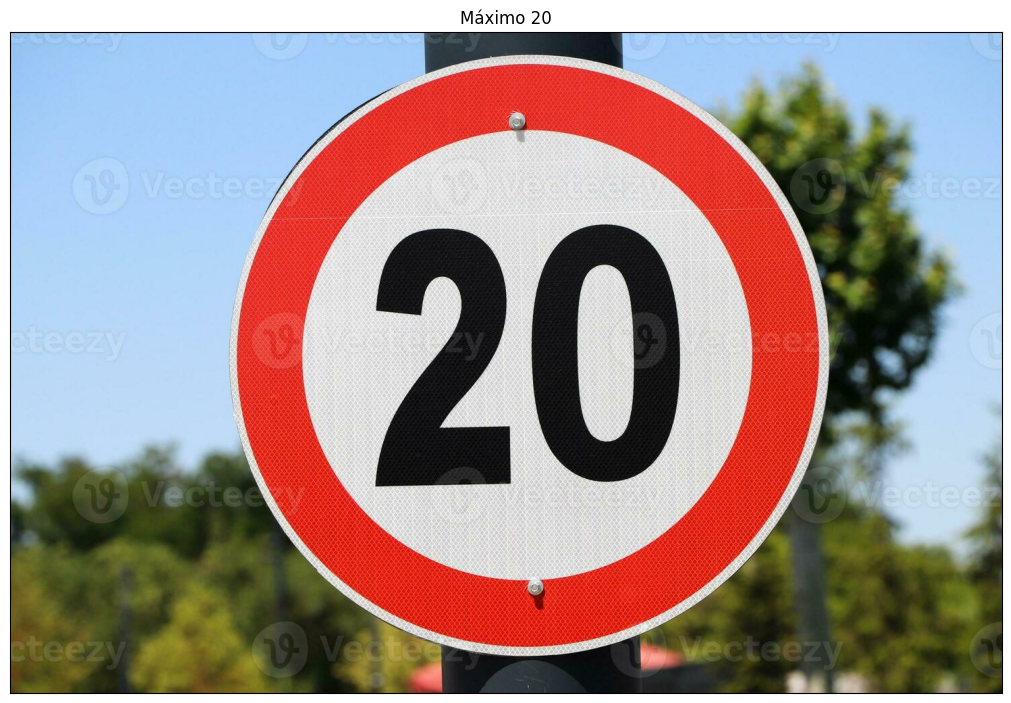

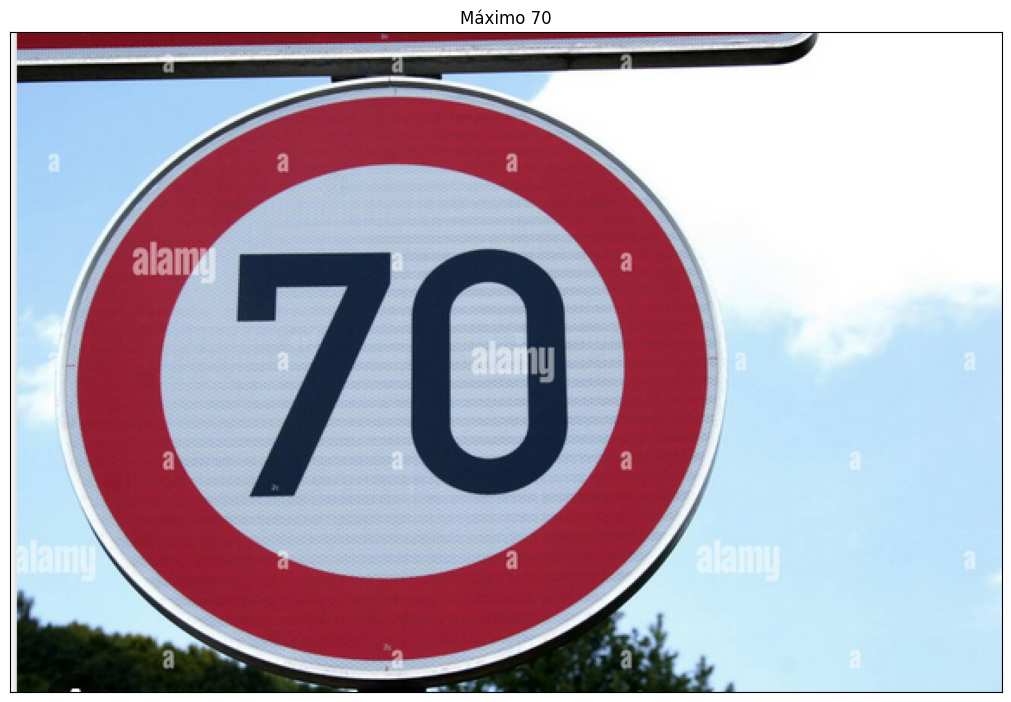

In [7]:
displayIm(maximo20,'Máximo 20')
displayIm(maximo70,'Máximo 70')

Se está en condiciones de comenzar el preprocesado de las imágenes. Nótese que la red neuronal trabaja con imágenes en blanco y negro, por lo que para trabajar con ellas primero hay que leerlas a color (para los ataques) pero después, al hacer la predicción, hay que pasarlas a blanco y negro. Para obtener las imágenes en blanco y negro y preprocesar se usan las siguientes funciones, obtenidas del repositorio usado como referencia. Mismos comentarios con el tamaño: lo normal es que el ataque se haga indendientemente del tamaño de la imagen, por lo que se redimensionará la imagen a un tamaño aceptado por la red cuando se busque clasificar la imagen (adversaria o limpia).

In [8]:
def grayscale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image


def equalize(image):
    image = cv2.equalizeHist(image)
    return image


def preprocessing(image):
    image = grayscale(image)
    # Adaptar la imagen a una dimensión 32x32, aceptada por keras
    image = cv2.resize(image,(32,32))
    image = equalize(image)
    image = image/255   # normalizar la imagen entre 0 y 1 en vez de 0 y 255
    return image

Ahora se obtienen las etiquetas correspondientes para cada caso.

In [9]:
import pandas as pd
import logging   # Para que no salgan los mensajes de cada predicción
import contextlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Devuelve la etiqueta predicha por el modelo de la imagen
def clasificacion(img):
  #salida = img.copy()

  # Preprocesado de la imagen para poder usarla en el modelo
  img = preprocessing(img)
  # Redimensionar según lo que espera el modelo
  img=img.reshape(1,32,32,1)
  # Probabilidades de asignar la predicción a cada clase. Se coge la de mayor probabilidad
  with suppress_stdout_stderr():
    prediccion = model.predict(img)

  probability = np.amax(prediccion) * 100
  class_pre = np.argmax(prediccion)
  # Leer el df donde están las etiquetas
  data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/TFG/CNN_senales_trafico/signnames.csv")
  # Asignar etiqueta según el diccionario
  class_pre_et = data.SignName[class_pre]

  return [class_pre_et,class_pre]

#%cd 'Colab Notebooks/TFG/CNN_senales_trafico'
#%ls
etiq_ceda_paso = clasificacion(cedaPaso)
etiq_maximo_100 = clasificacion(maximo100)
etiq_maximo_70 = clasificacion(maximo70)
etiq_direc_prohibida = clasificacion(direc_prohibida)
etiq_maximo_20 = clasificacion(maximo20)
print("La etiqueta para ceda el paso es "+str(etiq_ceda_paso))
print("La etiqueta para máximo a 100 es "+str(etiq_maximo_100))
print("La etiqueta para máximo a 70 es "+str(etiq_maximo_70))
print("La etiqueta para dirección prohibida es "+str(etiq_direc_prohibida))
print("La etiqueta para máximo a 20 es "+str(etiq_maximo_20))

La etiqueta para ceda el paso es ['Yield', 13]
La etiqueta para máximo a 100 es ['Speed limit (100km/h)', 7]
La etiqueta para máximo a 70 es ['Speed limit (70km/h)', 4]
La etiqueta para dirección prohibida es ['No passing', 9]
La etiqueta para máximo a 20 es ['Speed limit (20km/h)', 0]


Se han obtenido las etiquetas junto con su índice en el archivo .csv para poder tratarlas más adelante. Realizados estos pasos, ya se está en condiciones de empezar con la experimentación del TFG.

In [10]:
imagenes = [cedaPaso,maximo100,maximo70,direc_prohibida,maximo20]
etiquetas = [etiq_ceda_paso,etiq_maximo_100,etiq_maximo_70,etiq_direc_prohibida,etiq_maximo_20]
#print(imagenes)
print(etiquetas)

[['Yield', 13], ['Speed limit (100km/h)', 7], ['Speed limit (70km/h)', 4], ['No passing', 9], ['Speed limit (20km/h)', 0]]


##**Ataque teórico**

Se comienza aplicando un ataque teórico para poder presentar un ataque extraido de la propia teoría: "Los ejemplos adversario son innevitables, pues para toda imagen $x_0$, existe cierto $\delta$ ruido tal que si $f$ es el modelo (de red neuronal profunda) para clasificación, entonces $f(x_0) \neq f(x_0 + \delta)$". En el caso de redes neuronales convolucionales, sería ruido gaussiano. Es de **caja negra sin etiqueta**, pero es muy malo.

Para demostrar este ejemplo, se toman varias imágenes del conjunto de datos usado para test en el repositorio y se compara el ruido gaussiano necesario en cada imagen.

In [11]:
# imagen: A color
# etiqueta: 3-upla (ruido,etiqueta,número de etiqueta)
# Nota: Para simplificar el ejemplo, se supone que el ruido sigue una normal de media 0 y desviación típica 1
# Puede dar resultados o muy fuertes o muy débiles, por lo que no es un ataque muy usado

def teorico(imagen,etiqueta,mu=0,sigma=1):
  max_evals = 1000
  iterac = 0
  height,width,channels = imagen.shape
  media = mu
  desv_tip = sigma

  # Necesario para la condición de parada "hace fallar al modelo"
  prediccion = etiqueta
  while(prediccion==etiqueta and iterac<=max_evals):
    ruido_gaussiano = np.random.normal(media,desv_tip,(height,width,channels))
    adversario = (np.ceil(imagen+ruido_gaussiano)).astype(np.uint8)
    #displayIm(adversario)
    prediccion = clasificacion(adversario)
    iterac = iterac+1

  return [ruido_gaussiano,prediccion[0],prediccion[1],sigma,iterac-1]


Se fija, para el ruido gaussiano, $mu=0$. Se obtiene experimentalmente la desviación típica para cada imagen, mostrando $\sigma$ usado, iteraciones necesarias (para ver si ha conseguido o no encontrar una imagen adversario o se han acabado las iteraciones máximas) y las etiquetas tanto reales como predichas por la última iteración.

In [12]:
deltas = []  # Vector de vectores [matriz de ruido, nueva clasificación]_i, donde i es la imagen limpia
sigmas = [0.01, 0.1, 0.5, 1, 2, 5,7,8, 10, 20, 30, 50]

# Lista para almacenar los resultados
resultados = []

print("Número de imagen | Etiqueta real    | Etiqueta adversario | Sigma  | Iteraciones necesarias")
for i, (img, etiqueta) in enumerate(zip(imagenes, etiquetas), start=1):
    for sigma in sigmas:
        resultado = teorico(img, etiqueta, 0, sigma)
        deltas.append(resultado)
        # Almacenar los resultados en una lista
        resultados.append([i, etiqueta[0], resultado[1], sigma, resultado[4]])
        print(f"{i:<16} | {etiqueta[0]:<15} | {resultado[1]:<18} | {sigma:<5} | {resultado[4]:<25}")

    print("-" * 101)

# Crear un DataFrame de pandas para los resultados
df_resultados_teoria = pd.DataFrame(resultados, columns=['Número de imagen', 'Etiqueta real', 'Etiqueta adversario', 'Sigma', 'Iteraciones necesarias'])

# Mostrar la tabla comparativa
print(df_resultados_teoria)

Número de imagen | Etiqueta real    | Etiqueta adversario | Sigma  | Iteraciones necesarias
1                | Yield           | Yield              | 0.01  | 1000                     
1                | Yield           | Yield              | 0.1   | 1000                     
1                | Yield           | Yield              | 0.5   | 1000                     
1                | Yield           | Yield              | 1     | 1000                     
1                | Yield           | Yield              | 2     | 1000                     
1                | Yield           | Yield              | 5     | 1000                     
1                | Yield           | Yield              | 7     | 1000                     
1                | Yield           | Yield              | 8     | 1000                     
1                | Yield           | Road work          | 10    | 126                      
1                | Yield           | Road work          | 20    | 46            

Se termina almacenando los resultados en un archivo .csv para poder tratarlos si fuere necesario.

In [14]:
df_resultados_teoria.to_csv("/content/drive/My Drive/Colab Notebooks/TFG/CNN_senales_trafico/Resultados/teorico.csv")

##**Ataque FGSM**

Implementación del algoritmo que genera un ataque FGSM: se necesita el gradiente del modelo, luego es **caja blanca**. Además, es **no etiquetado** y, aunque dé buenos resultados, puede no ser útil en un ataque real.

In [15]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Necesario tener la imagen preprocesada
def patron_adversario(imagen, etiqueta_real):
   # imagen = tf.convert_to_tensor(imagen, dtype=tf.float32)
   # imagen = tf.reshape(imagen, (1, 32, 32, 1))  # Asegurar la forma correcta

    with tf.GradientTape() as tape:
        tape.watch(imagen)
        prediccion = model(imagen)
        etiqueta_one_hot = tf.one_hot([etiqueta_real], depth=43)   # Hay 43 etiquetas en el .csv
        perdida = loss_object(etiqueta_one_hot, prediccion)

    gradiente = tape.gradient(perdida, imagen)

    return tf.sign(gradiente)

def FGSM(imagen, etiqueta_real, epsilon):
    imagen_aux = preprocessing(imagen)
    imagen_aux = tf.convert_to_tensor(imagen_aux, dtype=tf.float32)
    imagen_aux = tf.reshape(imagen_aux, (1, 32, 32, 1))  # Asegurar la forma correcta

    # Estas dos líneas es para poder usar el ruido obtenido para FGSM
    imagen = cv2.resize(imagen, (32, 32))
    imagen = imagen / 255.0  # Normalizar la imagen entre 0 y 1
    imagen = tf.convert_to_tensor(imagen, dtype=tf.float32)
    imagen = tf.reshape(imagen, (1, 32, 32, 3))  # Asegurar la forma correcta
    signo = patron_adversario(imagen_aux, etiqueta_real[1])
    signo_color = tf.repeat(signo, 3, axis=-1)  # Expansión el gradiente para aplicar a la imagen a color
    #displayIm(signo_color)

    imagen_adversaria = imagen + epsilon * signo_color
    imagen_adversaria_np = tf.clip_by_value(imagen_adversaria, 0, 1)
    imagen_adversaria_np = imagen_adversaria.numpy().squeeze() * 255  # Quitar dimensiones adicionales y escalar a 255
    imagen_adversaria_np = imagen_adversaria_np.astype(np.uint8)  # Convertir a uint8 para mostrar

    return [imagen_adversaria_np,signo_color.numpy().squeeze()]  # Retornar la imagen adversaria en formato uint8

Se va a aplicar FGSM para todas las imágenes anteriores y diferentes epsilons para ver el posible resultado, guardándolo para poder tratarlo más adelante

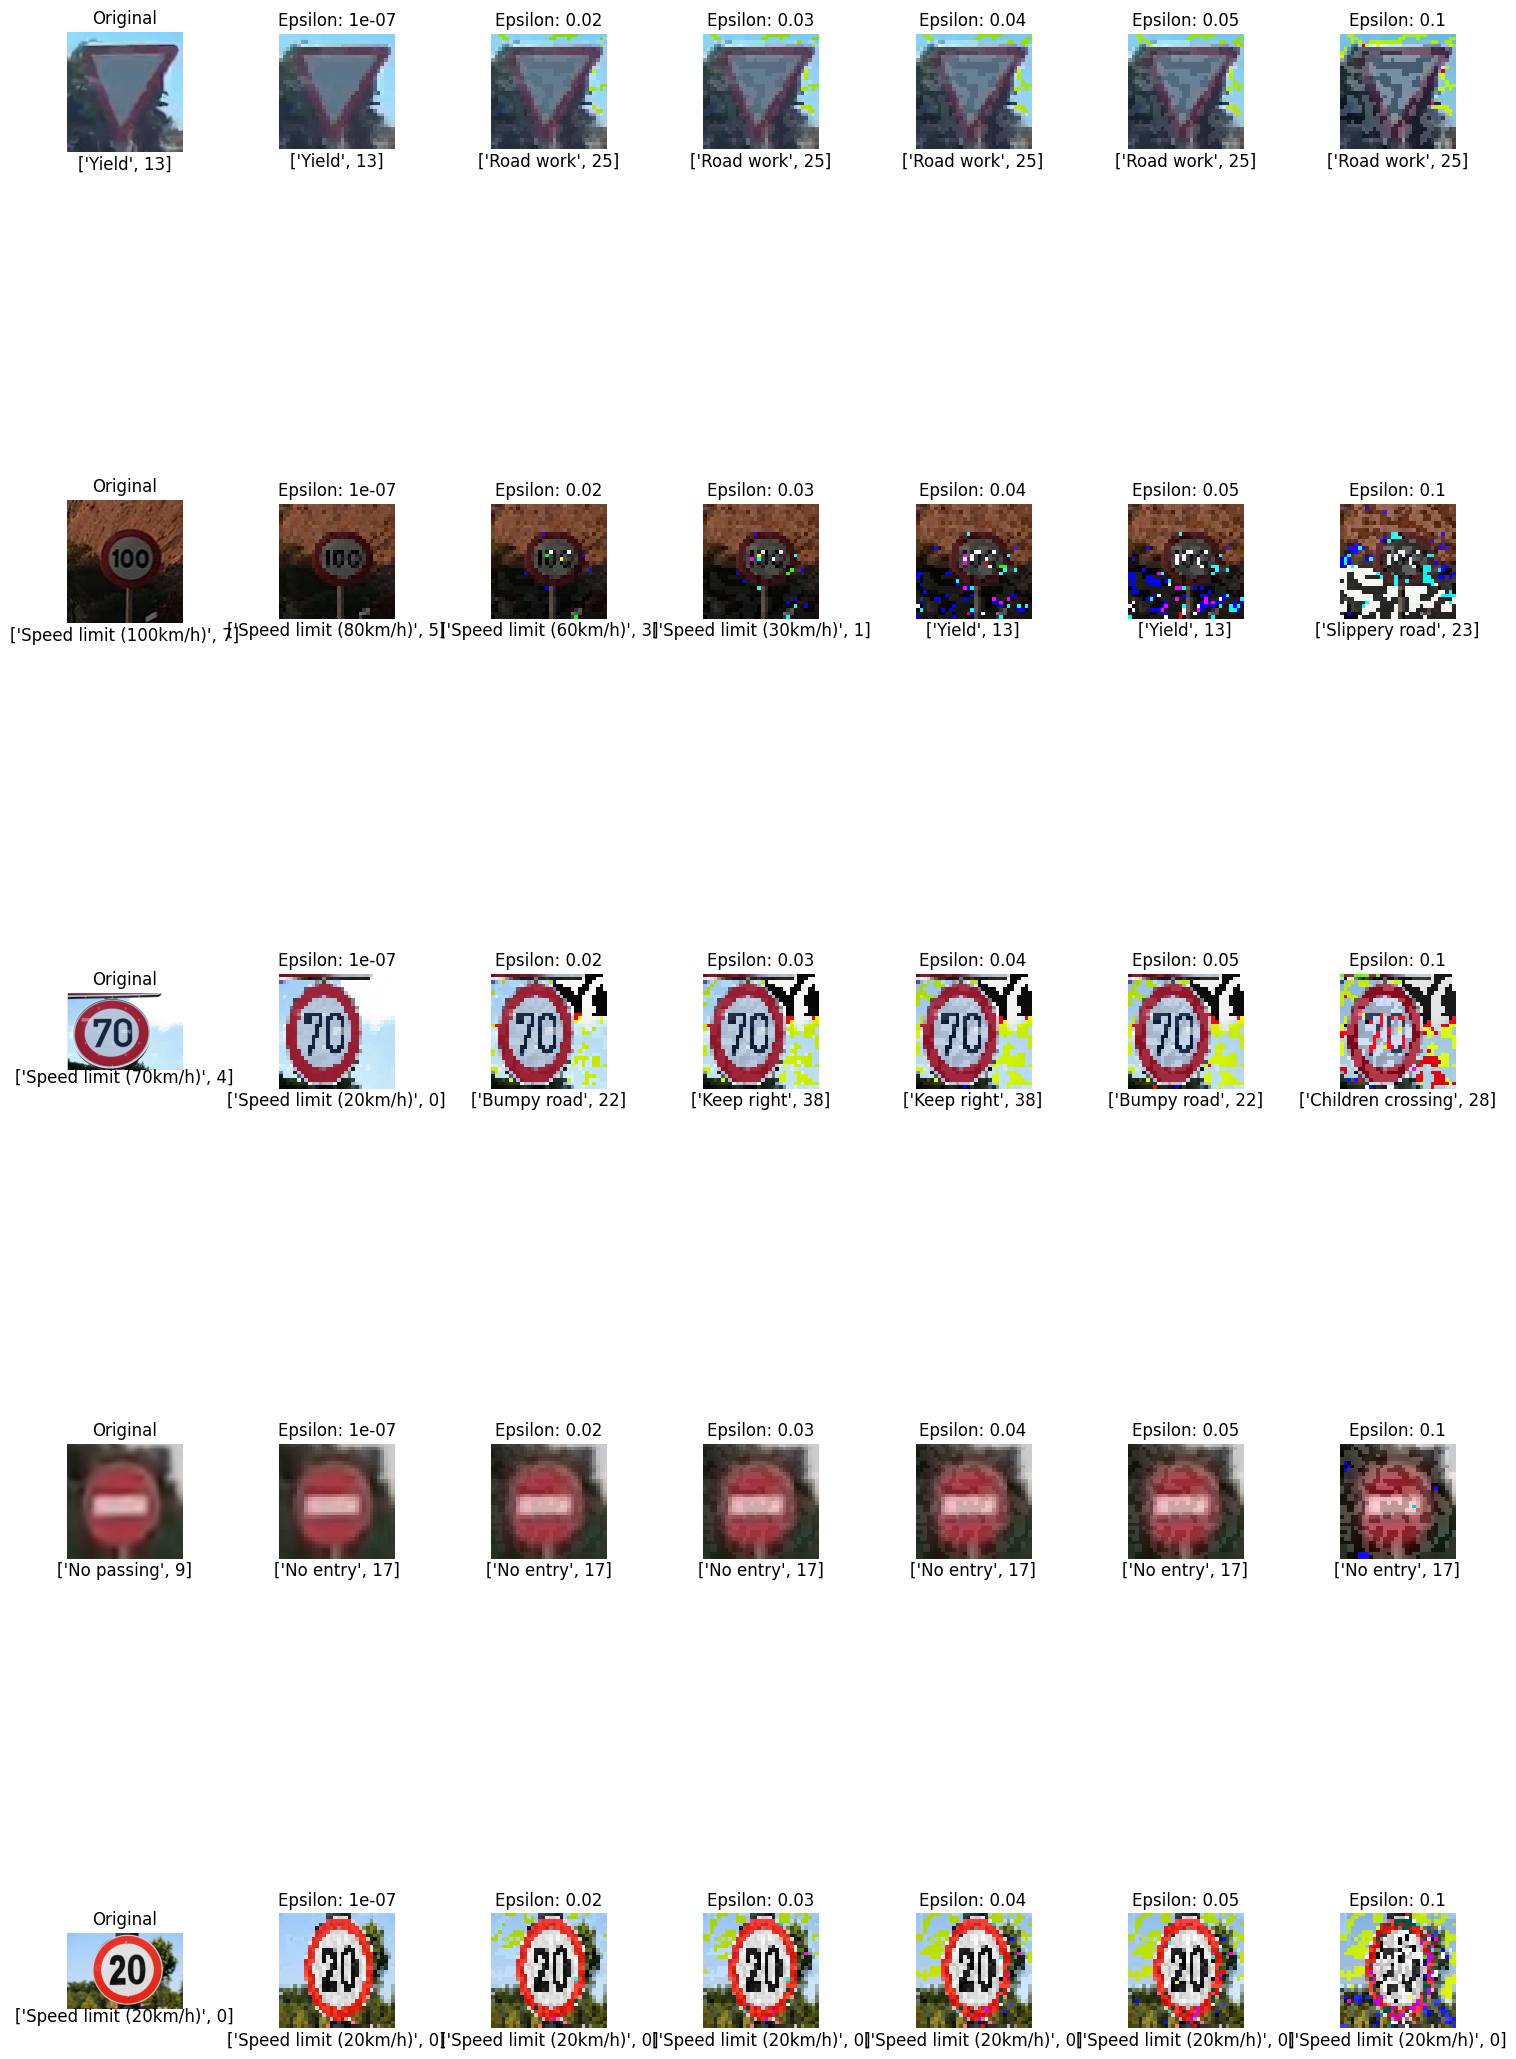

In [16]:
epsilons = [0.0000001,0.02,0.03,0.04,0.05,0.1]

# Lista para almacenar los resultados
results = []

# Crear una figura para visualizar las imágenes
fig, axes = plt.subplots(len(imagenes), len(epsilons) + 1, figsize=(15, len(imagenes) * 5))

for i, (image, label) in enumerate(zip(imagenes, etiquetas)):
    # Mostrar la imagen original
    axes[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    axes[i, 0].text(0.5, -0.1,str(label),
                    ha='center', va='center', transform=axes[i, 0].transAxes, fontsize=12)  # Clasificación debajo de la imagen original

    for j, epsilon in enumerate(epsilons):
        # Calcular el signo del gradiente y FGSM
        datos = FGSM(image, label, epsilon)

        # Mostrar la imagen perturbada
        axes[i, j + 1].imshow(cv2.cvtColor(datos[0], cv2.COLOR_BGR2RGB))
        pred_aux = clasificacion(datos[0])
        axes[i, j + 1].set_title(f'Epsilon: {epsilon}')
        axes[i, j + 1].axis('off')
        axes[i, j + 1].text(0.5, -0.1, f'{pred_aux}',
                            ha='center', va='center', transform=axes[i, j + 1].transAxes, fontsize=12)  # Clasificación debajo de la imagen perturbada

        # Almacenar los resultados en la lista
        results.append({
            'real_label': label[0],
            'predicted_label': pred_aux[0],
            'epsilon': epsilon,
            #'original_image': image,
            #'perturbed_image': datos[0],
            'gradient_sign': datos[1]
        })

# Ajustar el layout de la figura
plt.tight_layout()
plt.show()

# Convertir los resultados a un DataFrame de pandas
df_fgsm = pd.DataFrame(results)

In [ ]:
print(df_fgsm)

               real_label       predicted_label       epsilon  \
0                   Yield                 Yield  1.000000e-07   
1                   Yield             Road work  2.000000e-02   
2                   Yield             Road work  3.000000e-02   
3                   Yield             Road work  4.000000e-02   
4                   Yield             Road work  5.000000e-02   
5                   Yield             Road work  1.000000e-01   
6   Speed limit (100km/h)  Speed limit (80km/h)  1.000000e-07   
7   Speed limit (100km/h)  Speed limit (60km/h)  2.000000e-02   
8   Speed limit (100km/h)  Speed limit (30km/h)  3.000000e-02   
9   Speed limit (100km/h)                 Yield  4.000000e-02   
10  Speed limit (100km/h)                 Yield  5.000000e-02   
11  Speed limit (100km/h)         Slippery road  1.000000e-01   
12   Speed limit (70km/h)  Speed limit (20km/h)  1.000000e-07   
13   Speed limit (70km/h)            Bumpy road  2.000000e-02   
14   Speed limit (70km/h)

In [17]:
# Guardar el DataFrame en un archivo CSV
df_fgsm.to_csv('/content/drive/My Drive/Colab Notebooks/TFG/CNN_senales_trafico/Resultados/fgsm_results.csv')

print("Resultados almacenados en 'fgsm_results.csv'")

Resultados almacenados en 'fgsm_results.csv'


##**Búsqueda local adversaria**

Se toma como referencia la mostrada en la memoria del TFG: tomar como función objetivo la probabilidad de que la red clasifique con la etiqueta correcta y aplicar búsqueda local para minimizar la función objetivo. *Mi propuesta*: Dada la imagen $I$ con etiqueta real $c$, quiero que $f$ la clasifique como $c'$, tenemos:

- $g$: La función objetivo es la probabilidad de que $f$ clasifique una imagen como $c'$.

- Algoritmo: Búsqueda local para maximizar $g$.

En resumen, el enfoque del artículo es no etiquetado. El que propongo es etiquetado (más interesante pero puede que se note más la manipulación de la imagen).

**Condición**: Preprocesar la imagen para tratarla en blanco y negro. Prefijar la etiqueta que quiero. Para este ejercicio solo se fijará la etiqueta de "máximo 20" y se pasarán las imágenes máximo a 70 y dirección prohibida (es más real la primera, por compartir similitudes, y en un vehículo autónomo provocar un accidente).

In [18]:
index_objective_label = 0   # Máximo 20

# Se supone que 'imagen' es el resultado de preprocessing
def funcionObjetivo(imagen):
  aux = preprocessing(imagen).copy()
  aux=aux.reshape(1,32,32,1)

  with suppress_stdout_stderr():
    prediccion = model.predict(aux)

  return prediccion[0][index_objective_label]

Usando la función objetivo antes definida, se implementa búsqueda local dada una imagen para maximizar la función.

In [19]:
import random
from PIL import Image

def mezclarIndices(n_elems, indexes, inicializar):
    if inicializar:
        for i in range(0, n_elems):
            indexes.append(i)
    random.shuffle(indexes)

def mutacionBL(imagen_array, centro, altura_mitad=10, longitud_mitad=10, media=0, desviacion_estandar=10):
    h, w, c = imagen_array.shape
    x, y = centro
    x_min = max(0, x - altura_mitad)
    x_max = min(h, x + altura_mitad)
    y_min = max(0, y - longitud_mitad)
    y_max = min(w, y + longitud_mitad)

    ruido = np.random.normal(loc=media, scale=desviacion_estandar, size=(x_max - x_min, y_max - y_min, c))

    #imagen_array[x_min:x_max, y_min:y_max, :] += ruido
    #imagen_array = np.clip(imagen_array, 0, 255)  # Asegurarse de que los valores se mantengan entre 0 y 255
    imagen_array[x_min:x_max, y_min:y_max, :] = np.clip(imagen_array[x_min:x_max, y_min:y_max, :] + ruido, 0, 255).astype(np.uint8)

    return imagen_array

def busqueda_local(imagen):
    solucion = [np.array(imagen.copy()), funcionObjetivo(imagen.copy())]

    max_iteraciones = 2000
    num_iter = 1
    n_vecinos_generados_sin_mejora = 0
    hubo_mejora = True
    salir = False
    n_elementos_imagen = solucion[0].shape[0] * solucion[0].shape[1]
    indexes = []
    mezclarIndices(n_elementos_imagen, indexes, True)

    while hubo_mejora and num_iter <= max_iteraciones and n_vecinos_generados_sin_mejora < 20 * n_elementos_imagen:
        hubo_mejora = False
        salir = False
        j=0

        while j < len(indexes) and (not hubo_mejora) and (not salir):
            vecino = solucion[0].copy()
            index_2d = (indexes[j] // solucion[0].shape[1], indexes[j] % solucion[0].shape[1])
            mutacionBL(vecino, index_2d)

            fitness_vecino = funcionObjetivo(vecino)

            num_iter = num_iter + 1

            if fitness_vecino > solucion[1]:
                solucion[0] = vecino
                solucion[1] = fitness_vecino
                hubo_mejora = True
            else:
                n_vecinos_generados_sin_mejora = n_vecinos_generados_sin_mejora + 1

            j=j+1

        if hubo_mejora:
            n_vecinos_generados_sin_mejora = 0
            mezclarIndices(n_elementos_imagen, indexes, False)

    return solucion

In [20]:
maximo70_adversario = busqueda_local(maximo70)

In [21]:
direc_prohibida_adversario = busqueda_local(direc_prohibida)

In [22]:
etiq_bl_maximo70 = clasificacion(maximo70_adversario[0])
etiq_dir_prob_adversario = clasificacion(direc_prohibida_adversario[0])

In [23]:
print("La imagen de máximo a 70 adversario clasifica como "+str(etiq_bl_maximo70[0])+" con probabilidad "+str(maximo70_adversario[1]))
print("La imagen de máximo a 70 adversario clasifica como "+str(etiq_dir_prob_adversario[0])+" con probabilidad "+str(direc_prohibida_adversario[1]))

La imagen de máximo a 70 adversario clasifica como Speed limit (20km/h) con probabilidad 0.99999714
La imagen de máximo a 70 adversario clasifica como Speed limit (20km/h) con probabilidad 0.9999999


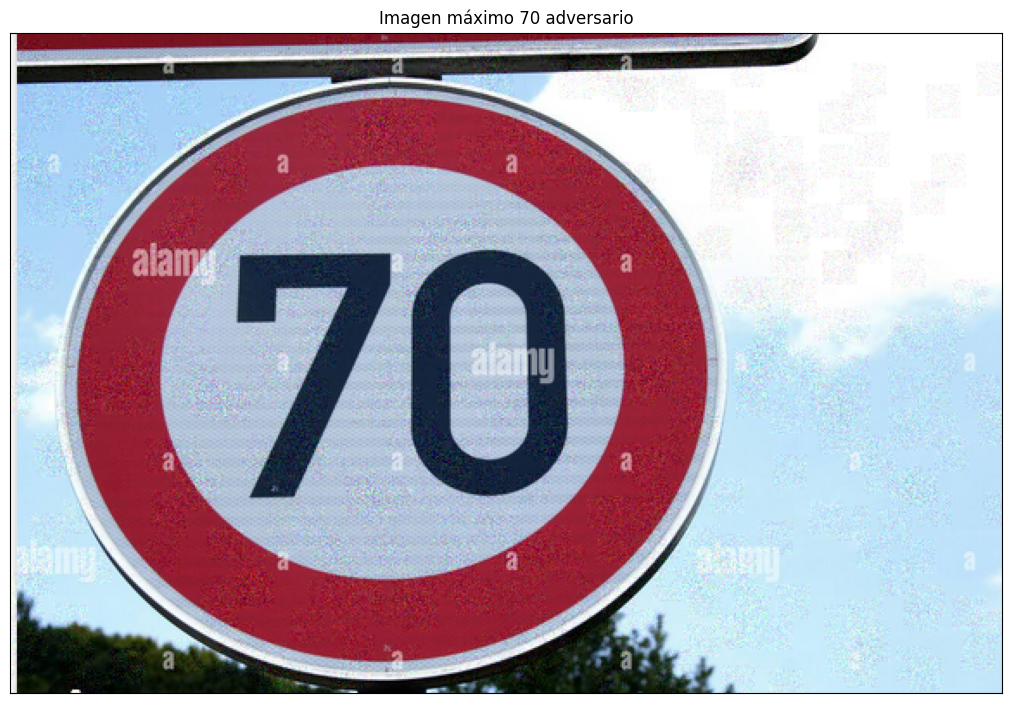

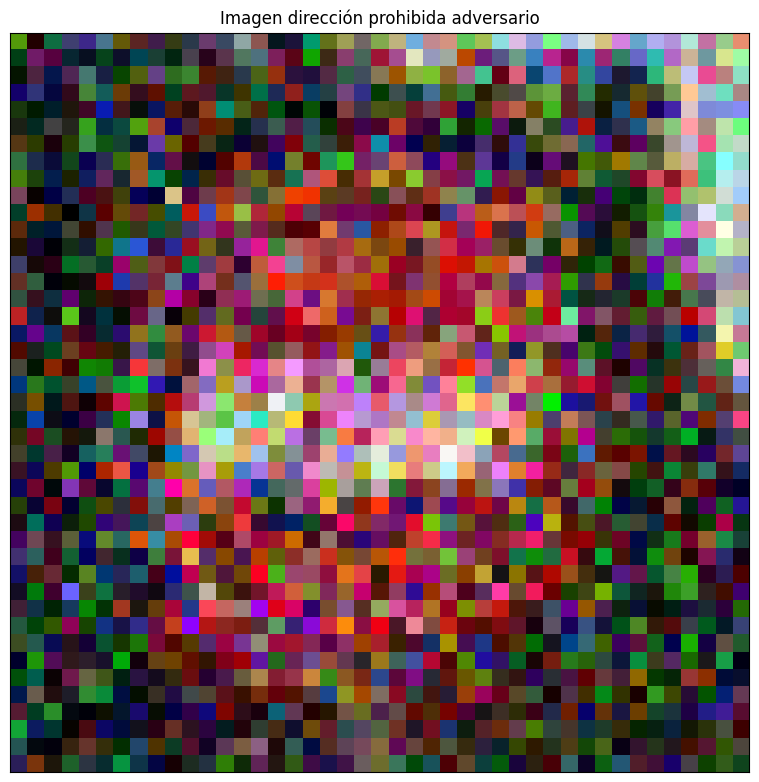

In [24]:
displayIm(maximo70_adversario[0],'Imagen máximo 70 adversario')
displayIm(direc_prohibida_adversario[0],'Imagen dirección prohibida adversario')

In [27]:
data_m70 = {
    "Etiqueta real": [etiquetas[2][0]],
    "Etiqueta adversaria": [etiq_bl_maximo70[0]],
    "Probabilidad de pertenencia a clase adversaria": [maximo70_adversario[1]],
    "Imagen adversaria": [maximo70_adversario[0]]
}

df1 = pd.DataFrame(data_m70)

data_dir_prob = {
    "Etiqueta real": [etiquetas[3][0]],
    "Etiqueta adversaria": [etiq_dir_prob_adversario[0]],
    "Probabilidad de pertenencia a clase adversaria": [direc_prohibida_adversario[1]],
    "Imagen adversaria": [direc_prohibida_adversario[0]]
}

df2 = pd.DataFrame(data_dir_prob)

df_combined = pd.concat([df1,df2],ignore_index=True)

df_combined.to_csv("/content/drive/My Drive/Colab Notebooks/TFG/CNN_senales_trafico/Resultados/resultados_BL_propuesto.csv",index=False)
print("Datos guardados con éxito")

Datos guardados con éxito


**Ataques de caja negra etiquetados con RGF**

Se implementa y se prueba tanto para la señal de máximo 20 (objetivo que detecte máximo 70), dirección prohibida (objetivo que detecte ceda el paso)  y señal de máximo 70 (objetivo que detecte máximo 20).

Primero programamos las funciones auxiliares al algoritmo, como aquella que calcula el valor de la $g$ propuesta por los autores.

In [13]:
def calcularg(imagen,theta,previo_valor,y0,epsilon=0.001,alpha=0.01):
  norma = np.linalg.norm(theta)
  theta = theta / norma

  pred = clasificacion(imagen+previo_valor*theta)

  if(pred[1] == y0):
    v_left = previo_valor
    v_right = (1+alpha)*previo_valor
    pred_2 = clasificacion(imagen+v_right*theta)

    while(pred_2[1] == y0):
      v_right = (1+alpha)*v_right
  else:
    v_right = previo_valor
    v_left = (1-alpha)*v_left

  # Aplicamos búsqueda binario en [v_left,v_right]
  while(v_right-v_left > epsilon):
    v_mid=(v_right+v_left)/2

    predi_3 = clasificacion(imagen+v_mid*theta)
    if(predi_3[1] == y0):
      v_left = v_mid
    else:
      v_right = v_mid

  return v_right


Ahora se implementa el algoritmo principal del artículo.

In [ ]:
def ataqueConRGF(imagen,theta0,y0,sigma,beta,lr,epsilon=0.001,alpha=0.01):
  max_iters = 1000
  theta_t = theta0
  v = 0

  for i in range(0,max_iters):
    u=np.random.normal(0,sigma,len(theta0)) # Requisito que provenga de una normal con media nula
    eval_theta_t = calcularg(imagen,theta_t,v,etiqueta_objetivo,epsilon,alpha)
    eval_siguiente = calcularg(imagen,theta_t + beta*u,v,etiqueta_objetivo,epsilon,alpha)

    v = eval_theta_t

    g_gorro = ((eval_siguiente - eval_theta_t)/beta) * u
    theta_t = theta_t - lr*g_gorro

  return imagen+calcularg(imagen,theta_t,v,etiqueta_objetivo,epsilon,alpha)*theta_t

In [ ]:
maximo20_adversario = ataqueConRGF(maximo20,theta0,4,beta,lr)